# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


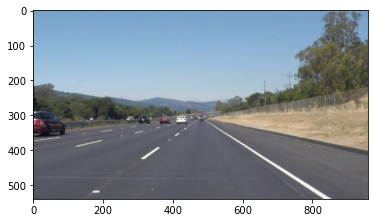

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_length, max_line_gap,top,bottom,centerLine):
    #hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap,top,bottom,centerLine)
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Parameters Images

In [5]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 7

#The parameters for the OpenCV Canny edge
# Define our parameters for Canny and apply
#We establish a ratio of lower:upper threshold of 3:1 (with the variable ratio).

low_threshold = 90 #60
high_threshold = 150 #170

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on

rho = 1 #2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 9 # 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 130 # 110 #minimum number of pixels making up a line
max_line_gap = 190  # 180  # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

top = 340
bottom = 540
centerLine = (450+520)/2.0

In [ ]:
 os.mkdir("test_images_output")

True

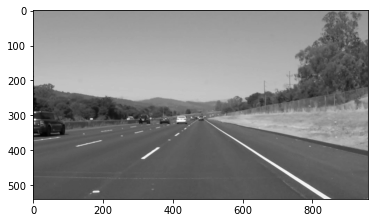

In [6]:
# Lesson 4 Canny to Detectect Lane Lines

#import cv2  #bringing in OpenCV libraries
#gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
#plt.imshow(gray, cmap='gray')


img_gray = grayscale(image)
plt.imshow(img_gray, cmap='gray') # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# save image
cv2.imwrite('test_images_output/img_gray.jpg', img_gray)

## Apply Gaussian smoothing

True

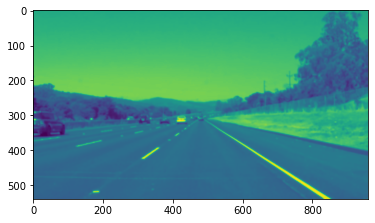

In [7]:
gauss_blur = gaussian_blur(img_gray, kernel_size)
plt.imshow(gauss_blur)

# save image
cv2.imwrite('test_images_output/gauss_blur.jpg', gauss_blur)

## Canny to Detect Lane Lines

True

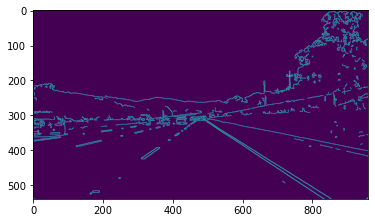

In [8]:
#Canny to Detect Lane Lines
edges = canny(image, low_threshold, high_threshold)
plt.imshow(edges)

# save image
cv2.imwrite('test_images_output/edges.jpg', edges)

### Create a Masked Edges Image

True

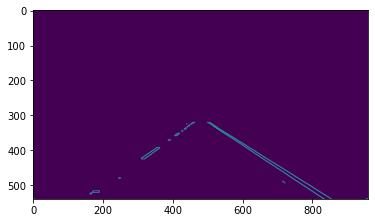

In [9]:
# We'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   
# This time we are defining a four sided polygon to mask

imshape = image.shape
#vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
vertices = np.array([[(0,imshape[0]),(450, 320), (540, 320), (imshape[1],imshape[0])]], dtype=np.int32)
#vertices = np.array([[(120,imshape[0]),(450, 330), (520, 330), (900,imshape[0])]], dtype=np.int32)
mask_edges = region_of_interest(edges, vertices)
plt.imshow(mask_edges)

# save image
cv2.imwrite('test_images_output/mask_edges.jpg', mask_edges)

True

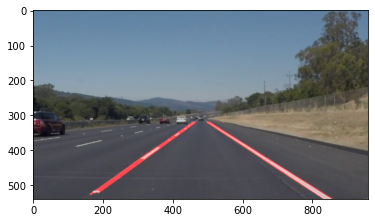

In [10]:
lines = hough_lines(mask_edges, rho, theta, threshold, min_line_length, max_line_gap,top,bottom,centerLine)
plt.imshow(weighted_img(lines, image))

# save image
cv2.imwrite('test_images_output/lines.jpg', lines)

In [11]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def find_lanes(img):
    """
    `img` can be either color image or grayscale image.
        
    Returns an image with hough lines drawn.
    """
    # check whether this is color image or gray image
    if len(img.shape)>2:
        imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        imgGray = img
    
    # Parameters
    low_threshold = 10 # 70
    high_threshold =30 # 220
    kernel_size = 3
    rho = 1
    theta = np.pi/180
    threshold = 6  # 15
    min_line_length = 20 # 110 # min_line_len and max_line_gap (>100)  
    max_line_gap = 50   # 150  
    imshape = img.shape
    vertices = np.array([[(120,imshape[0]),(450, 330), (520, 330), (900,imshape[0])]], dtype=np.int32)
    top = 340
    bottom = 539
    centerLine = (450+520)/2.0
    
    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(imgGray,kernel_size)
    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Define ROI
    masked_edges =region_of_interest(edges, vertices)
    # Run Hough on edge detected image
    color_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap,top,bottom,centerLine)
    
    # Draw lanes on original images
    combo = weighted_img(img,color_edges)
    
    return combo

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #def find_lanes(img):
    """
    `img` can be either color image or grayscale image.
        
    Returns an image with hough lines drawn.
    """
    # check whether this is color image or gray image
    if len(image.shape)>2:
        imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        imgGray = image
    
    # Parameters
    low_threshold = 190
    high_threshold = 290
    kernel_size = 5
    rho = 1
    theta = np.pi/180
    threshold = 7
    min_line_length = 40
    max_line_gap = 120
    imshape = image.shape
    vertices = np.array([[(120,imshape[0]),(450, 330), (520, 330), (900,imshape[0])]], dtype=np.int32)
    top = 340
    bottom = 539
    centerLine = (450+520)/2.0
    
    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(imgGray,kernel_size)
    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Define ROI
    masked_edges =region_of_interest(edges, vertices)
    # Run Hough on edge detected image
    color_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap,top,bottom,centerLine)
    
    # Draw lanes on original images
    combo = weighted_img(image,color_edges)
    
    return combo

    #return result

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 8.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #def find_lanes(img):
    """
    `img` can be either color image or grayscale image.
        
    Returns an image with hough lines drawn.
    """
    # check whether this is color image or gray image
    if len(image.shape)>2:
        imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        imgGray = image
    
    # Parameters
    low_threshold = 40
    high_threshold = 180
    kernel_size = 5
    rho = 1
    theta = np.pi/180
    threshold = 7
    min_line_length = 40
    max_line_gap = 60
    imshape = image.shape
    vertices = np.array([[(120,imshape[0]),(450, 330), (520, 330), (900,imshape[0])]], dtype=np.int32)
    top = 340
    bottom = 539
    centerLine = (450+520)/2.0
    
    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(imgGray,kernel_size)
    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Define ROI
    masked_edges =region_of_interest(edges, vertices)
    # Run Hough on edge detected image
    color_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap,top,bottom,centerLine)
    
    # Draw lanes on original images
    combo = weighted_img(image,color_edges)
    
    return combo

    #return result

In [17]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 26 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [19]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    #def find_lanes(img):
    """
    `img` can be either color image or grayscale image.
        
    Returns an image with hough lines drawn.
    """
    # check whether this is color image or gray image
    if len(image.shape)>2:
        imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        imgGray = image
    
    # Parameters
    low_threshold = 250
    high_threshold = 350
    kernel_size = 5
    rho = 2
    theta = np.pi/180
    threshold = 3
    min_line_length = 110
    max_line_gap = 130
    imshape = image.shape
    vertices = np.array([[(120,imshape[0]),(450, 330), (520, 330), (900,imshape[0])]], dtype=np.int32)
    top = 360
    bottom = 539
    centerLine = (350+420)/3.0
    
    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(imgGray,kernel_size)
    # Define our parameters for Canny and apply
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Define ROI
    masked_edges =region_of_interest(edges, vertices)
    # Run Hough on edge detected image
    color_edges = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap,top,bottom,centerLine)
    
    # Draw lanes on original images
    combo = weighted_img(image,color_edges)
    
    return combo

    #return result

In [20]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



t:  57%|██████████████████████████████████████▏                            | 143/251 [00:09<00:10, 10.28it/s, now=None]

TypeError: 'NoneType' object is not iterable

t:  57%|██████████████████████████████████████▍                            | 144/251 [00:20<00:10, 10.28it/s, now=None]

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# **Finding Lane Lines on the Road** 

Overview
---

When we drive, we use our eyes to decide where to go. The lines on the road show us where the lanes act as our constant reference for where to steer the vehicle. Naturally, one of the first things we would like to do in developing a self-driving car is to automatically detect lane lines using an algorithm. 

This project aims to create a pipeline that finds lane lines on the road using Canny edge detection, image masking, and Hough transforms through OpenCV.



---
* Make a pipeline that finds lane lines on the road
* Reflect on your work in a written report


[//]: # (Image References)

[image1]: ./examples/grayscale.jpg "Grayscale"

---

### Reflection

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.

My pipeline consisted of 5 steps.

* Convert the images to grayscale.
* Apply Gaussian smoothing


### Step 1 Convert Grayscale image

Many computer vision and image processing algorithms (Canny, Hough, Sobel) use grayscale images instead of color images. To detect white or yellow lines in images, it is useful to create particularly high contrast in the image. Converting to grayscale helps us with this task in addition to reducing noise even more. This step is also part of the image preprocessing before running more powerful algorithms to isolate lines.

![Grayscale Image](test_images_output/img_gray.jpg)

### Step 2 apply Gaussian smoothing

In this method, instead of a box filter, a Gaussian kernel is used. It is done with the function, cv.GaussianBlur(). We should specify the width and height of the kernel which should be positive and odd.   Gaussian blurring is highly effective in removing Gaussian noise from an image.

![Gaussian smoothing](test_images_output/gauss_blur_2.jpg)


### Step 3 Canny Edge Detection

Canny edge detection is a technique to extract useful structural information from different vision objects and dramatically reduce the amount of data to be processed. It has been widely applied in various computer vision systems. Canny has found that the requirements for the application of edge detection on diverse vision systems are relatively similar. Thus, an edge detection solution to address these requirements can be implemented in a wide range of situations.

![Canny Edge Detection](test_images_output/edges.jpg)


### Step 4 Create a Masked Edges Image

Using an edge mask to focus images on. It is useful for sharpening the edges, particularly when details or used to define the region of interest are required formed by a polygon from vertices. The rest of the image is set to black.

![Create a Masked Edges Image](test_images_output/mask_edges.jpg)


### Step 5 Using the Hough Transform to Find Lines 

The Hough transform is a feature extraction technique used in image analysis, computer vision, and digital image processing. The technique's purpose is to find imperfect instances of objects within a certain class of shapes by a voting procedure. This voting procedure is carried out in parameter space. Object candidates are obtained as local maxima in a so-called accumulator space explicitly constructed by the algorithm for computing the Hough transform.

![Using the Hough Transform to Find Lines ](test_images_output/lines.jpg)


### Draw Lines

In order to draw a single line on the left and right lanes, I modified the draw_lines () function by find_lines () to change the size of the ROI mask to limit the lane capture area, which could filter out more noise.
Then, increase the threshold of the minimum number of votes, the model could identify the lane more precisely, as learned in the Hough Transformation. The large intersection number in a Hough Space refers to a possible line in the Space image. It could help to reduce the interference in the area of the vertices.

Parameter Settings.

For the Canny high_treshold function, it was tuned up a bit to help better filter the white lane of the image. values> 100 were used

The min_line_length values were also adjusted much larger to avoid capturing extremely short lines or points.

A larger max_line_gap setting prevents lane segmenting.


![Using the Hough Transform to Find Lines ](test_images_output/Lines_2.jpg)




---

### Test Video


[Finding Lane Lines Solid White Right Lines](https://youtu.be/Cn-RkulyO4E)

[Finding Lane Lines Solid Yellow Left Lines](https://youtu.be/Xzt9AzoNvgw)



### 2. Identify potential shortcomings with your current pipeline


A potential deficiency would be when the road is under repair, and there are no road lines.


Another deficiency could be identifying the lines if the road is in poor condition with cracks or there are on the road.


### 3. Suggest possible improvements to your pipeline

A possible improvement would be to apply Machine Learning to use some prediction to guess where the lines should be based on the previous frames until lines are detected again.

Another potential improvement could be when an algorithm that detects the lane lines within the region of interest could be extended in the polygon, in this way; it could improve the detection in case of eventualities such as a car that invades the lane or the road in poor condition.